In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sktime.forecasting.compose import make_reduction
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.utils.plotting import plot_series
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('AirPassengers.csv', index_col=0)
idx = pd.to_datetime( df.index ,dayfirst=True).to_period("M")
df.index = idx
df.head()

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


(138,) (6,)


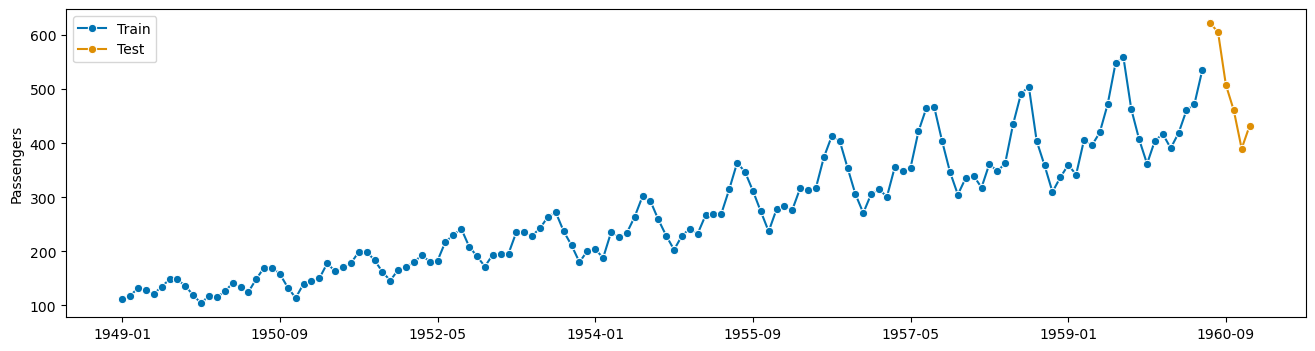

In [4]:
y = df['Passengers']
y_train, y_test = temporal_train_test_split(y,test_size=6)
print(y_train.shape, y_test.shape)
plot_series(y_train, y_test, labels=["Train", "Test"])
plt.show()

In [5]:
fh = np.arange(1, len(y_test) + 1)
fh

array([1, 2, 3, 4, 5, 6])

In [6]:
regressor = RandomForestRegressor(random_state=23)
forecaster = make_reduction(regressor,window_length=10)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
rmse = MeanSquaredError(square_root=True)
print(rmse(y_test, y_pred))

85.93190598762875


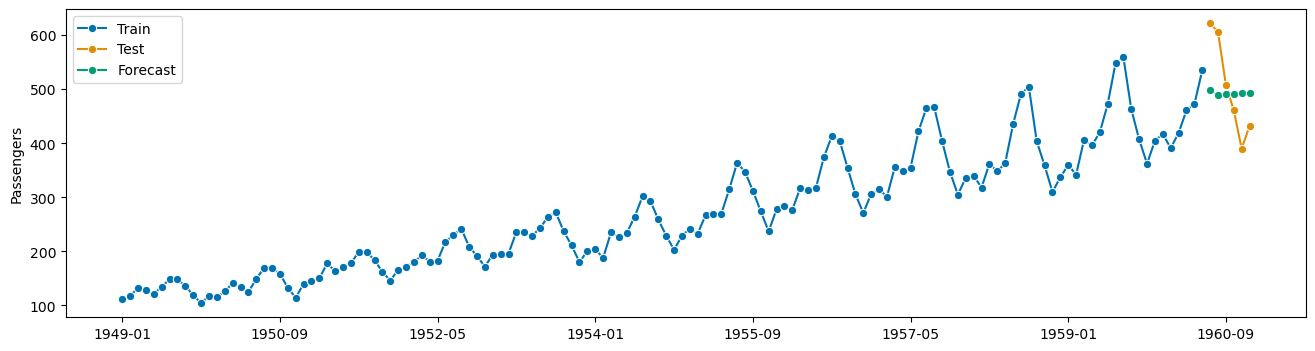

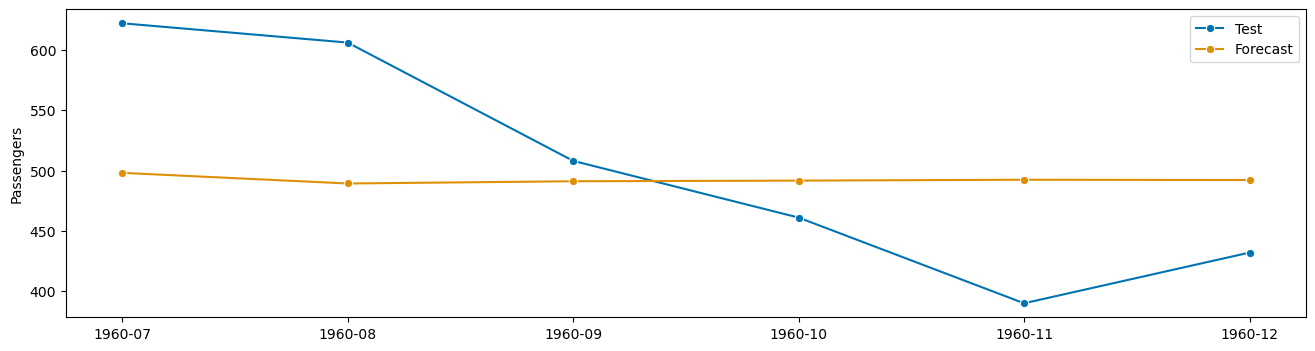

In [7]:
plot_series(y_train,y_test,y_pred , labels=['Train','Test','Forecast'])
plt.show()
plot_series(y_test,y_pred , labels=['Test','Forecast'])
plt.show()

## Basic Grid Search

In [8]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV, SlidingWindowSplitter

In [9]:
forecaster = make_reduction(regressor, strategy="recursive")
params = {"window_length": [7, 10, 12, 15]}

We fit the forecaster on an initial window which is 80% of the historical data. Then use temporal sliding window cross-validation to find the optimal hyper-parameters.

In [10]:
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8))
gscv = ForecastingGridSearchCV( forecaster, strategy="refit", cv=cv, param_grid=params)
gscv.fit(y_train)
y_pred = gscv.predict(fh)
print(gscv.best_params_)
print(gscv.best_score_)

{'window_length': 10}
0.06005524861878456


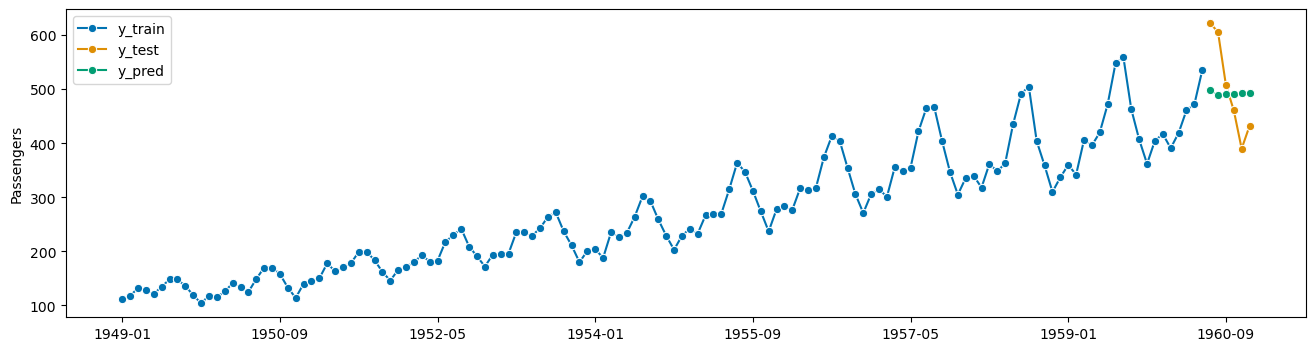

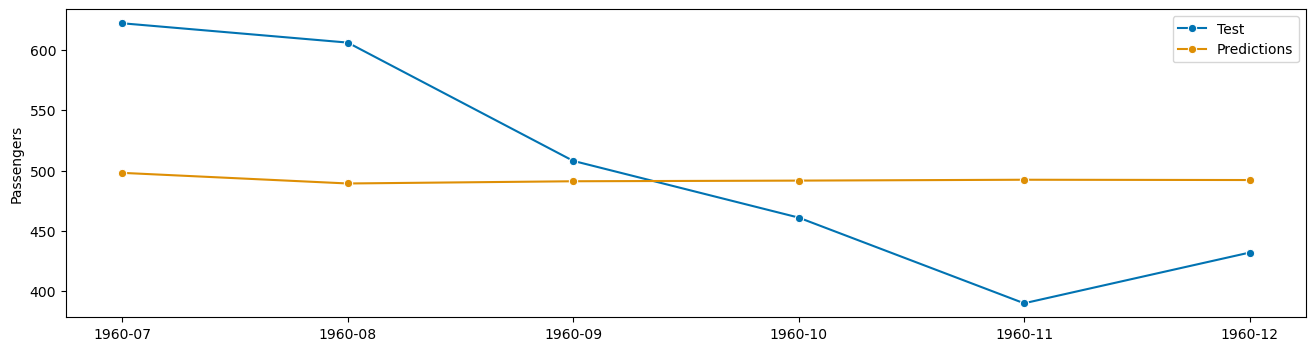

In [11]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
plt.show()
plot_series(y_test, y_pred, labels=["Test", "Predictions"])
plt.show()

In [12]:
rmse = MeanSquaredError(square_root=True)
print(rmse(y_test, y_pred))

85.93190598762875


## Composite Grid Search

In [13]:
params = {"window_length": [7,10, 12, 15],
              'estimator__max_features':['auto', 'sqrt', 'log2']}
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8))
gscv = ForecastingGridSearchCV( forecaster, strategy="refit", cv=cv, param_grid=params)
gscv.fit(y_train)
y_pred = gscv.predict(fh)
print(gscv.best_params_)
print(gscv.best_score_)

{'estimator__max_features': 'sqrt', 'window_length': 15}
0.014668508287292823


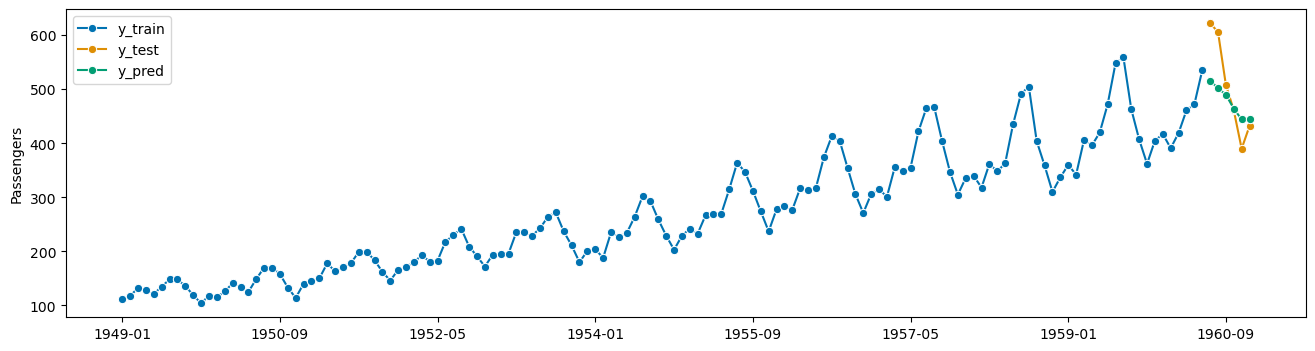

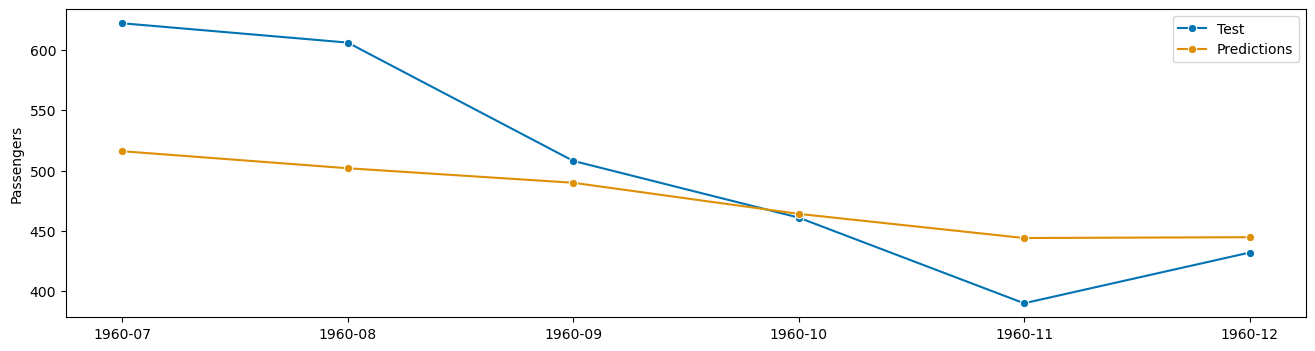

In [14]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
plt.show()
plot_series(y_test, y_pred, labels=["Test", "Predictions"])
plt.show()

In [15]:
rmse = MeanSquaredError(square_root=True)
print(rmse(y_test, y_pred))

65.19417867672952
